In [1]:
# Step 1. Import Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier   # You can change model here


In [7]:
# Step 2. Load UNSW-NB15 Parquet Training Set
from google.colab import files
import pandas as pd

# Upload the parquet file into Colab
uploaded = files.upload()

# Make sure filename matches the uploaded file
file_path = "UNSW_NB15_training-set.parquet"

# Load parquet dataset
df = pd.read_parquet(file_path)

print("✅ Dataset loaded!")
print("Shape:", df.shape)
print(df.head())
print(df.columns)   # check column names


Saving UNSW_NB15_training-set.parquet to UNSW_NB15_training-set (1).parquet
✅ Dataset loaded!
Shape: (175341, 36)
        dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0  0.121478   tcp       -   FIN      6      4     258     172  74.087486   
1  0.649902   tcp       -   FIN     14     38     734   42014  78.473373   
2  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4  0.449454   tcp       -   FIN     10      6     534     268  33.373825   

          sload  ...  trans_depth  response_body_len  ct_src_dport_ltm  \
0  14158.942383  ...            0                  0                 1   
1   8395.112305  ...            0                  0                 1   
2   1572.271851  ...            0                  0                 1   
3   2740.178955  ...            0                  0                 1   
4   8561.499023  ...            0                  0       

In [9]:
# Step 3. Preprocess Data

# Check missing values
print("Missing values per column:\n", df.isnull().sum())

# Fill missing values (if any)
df.fillna(df.mode().iloc[0], inplace=True)

# ======= Choose target =======
# Option 1: Binary classification (Normal vs Attack)
target_column = 'label'

# Option 2: Multi-class classification (Attack categories)
# target_column = 'attack_cat'

X = df.drop(columns=[target_column])
y = df[target_column]

# Identify categorical columns in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
print("Categorical columns to encode:", categorical_cols)

# Apply one-hot encoding to categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)

# Encode labels if categorical (needed for attack_cat)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize numerical features (now all features are numerical after encoding)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print("✅ Features shape:", X_scaled.shape)
print("✅ Labels shape:", y_encoded.shape)

Missing values per column:
 dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
is_sm_ips_ports      0
attack_cat           0
label                0
dtype: int64
Categorical columns to encode: Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')
✅ Features shape: (175341, 196)
✅

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (122738, 196)  Test size: (52603, 196)


In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("✅ Model training complete!")


✅ Model training complete!


In [12]:
# Step 6. Predict
y_pred = model.predict(X_test)
print("Sample Predictions:", y_pred[:10])


Sample Predictions: [1 0 0 1 1 1 0 1 1 1]


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score :", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))

Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-Score : 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16800
           1       1.00      1.00      1.00     35803

    accuracy                           1.00     52603
   macro avg       1.00      1.00      1.00     52603
weighted avg       1.00      1.00      1.00     52603



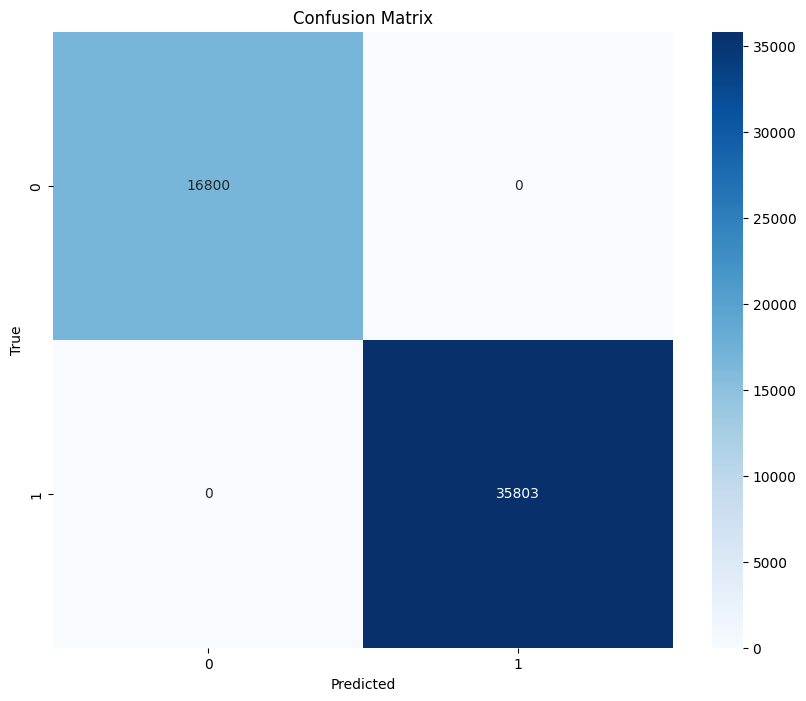

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [16]:
import joblib

joblib.dump(model, "unsw_model.pkl")
joblib.dump(label_encoder, "unsw_label_encoder.pkl")
joblib.dump(scaler, "unsw_scaler.pkl")

print("✅ Model, encoder, and scaler saved successfully!")


✅ Model, encoder, and scaler saved successfully!
